<a href="https://colab.research.google.com/github/debi201326/SAR-Flood-Detection/blob/main/sar_flood_detect_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

debasritach_sar_flood_data_path = kagglehub.dataset_download('debasritach/sar-flood-data')

print('Data source import complete.')


In [ ]:
import os
import cv2
import re
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T


In [ ]:
def lee_filter(img, size=5, eps=1e-8):
    """Numerically stable Lee filter for SAR images."""
    img = img.astype(np.float32)
    mean = cv2.blur(img, (size, size))
    mean_sq = cv2.blur(img**2, (size, size))
    variance = mean_sq - mean**2

    overall_variance = variance.mean()
    weight = variance / (variance + overall_variance + eps)
    weight = np.clip(weight, 0, 1)  # keep in [0,1]

    filtered = mean + weight * (img - mean)
    filtered = np.clip(filtered, 0, 255)  # keep pixel range
    return np.uint8(filtered)


In [ ]:
def natural_sort_key(s):
    """Helper for natural sorting (image_2.png before image_10.png)."""
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', s)]


In [ ]:
class SARFloodDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.A_paths = sorted(glob(os.path.join(root_dir, "A", "*.png")), key=natural_sort_key)
        self.B_paths = sorted(glob(os.path.join(root_dir, "B", "*.png")), key=natural_sort_key)
        self.label_paths = sorted(glob(os.path.join(root_dir, "Label", "*.png")), key=natural_sort_key)
        self.transform = transform

    def __len__(self):
        return min(len(self.A_paths), len(self.B_paths), len(self.label_paths))

    def __getitem__(self, idx):
        A = cv2.imread(self.A_paths[idx], cv2.IMREAD_GRAYSCALE)
        B = cv2.imread(self.B_paths[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(self.label_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Apply Lee filter
        A = lee_filter(A)
        B = lee_filter(B)

        # Stack into 2-channel input
        img = np.stack([A, B], axis=-1)

        # Convert to PIL
        img = Image.fromarray(img)
        label = Image.fromarray(label)

        if self.transform:
            img = self.transform(img)
            label = self.transform(label)

        return img, label


In [ ]:
print("A images:", len(glob("/kaggle/input/sar-flood-data/A/*.png")))
print("B images:", len(glob("/kaggle/input/sar-flood-data/B/*.png")))
print("Label images:", len(glob("/kaggle/input/sar-flood-data/Label/*.png")))


A images: 5360
B images: 5360
Label images: 5360


In [ ]:
# Transforms
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

# Load full dataset
full_dataset = SARFloodDataset(root_dir="/kaggle/input/sar-flood-data", transform=transform)

# Train/Validation Split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # fixed split
)

print(f"Train samples: {len(train_dataset)} | Validation samples: {len(val_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)


Train samples: 4288 | Validation samples: 1072


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

        self.dec3 = conv_block(512+256, 256)
        self.dec2 = conv_block(256+128, 128)
        self.dec1 = conv_block(128+64, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d3 = self.up(e4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)

            total_loss += loss.item()
            correct += ((preds > 0.5) == (masks > 0.5)).sum().item()
            total += masks.numel()

    return total_loss / len(loader), correct / total

# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss, val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss={train_loss/len(train_loader):.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1/5, Train Loss=0.1699, Val Loss=0.1317, Val Acc=0.9503
Epoch 2/5, Train Loss=0.1290, Val Loss=0.1268, Val Acc=0.9520
Epoch 3/5, Train Loss=0.1204, Val Loss=0.1273, Val Acc=0.9488
Epoch 4/5, Train Loss=0.1133, Val Loss=0.1140, Val Acc=0.9551
Epoch 5/5, Train Loss=0.1090, Val Loss=0.1212, Val Acc=0.9551


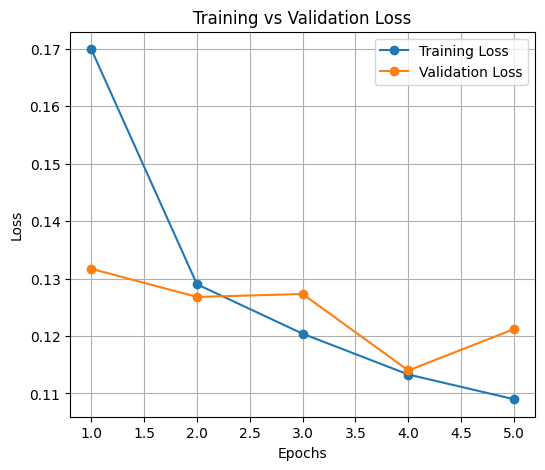

In [ ]:

# Loss values from your training logs
train_losses = [0.1699, 0.1290, 0.1204, 0.1133, 0.1090]
val_losses   = [0.1317, 0.1268, 0.1273, 0.1140, 0.1212]

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(6,5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


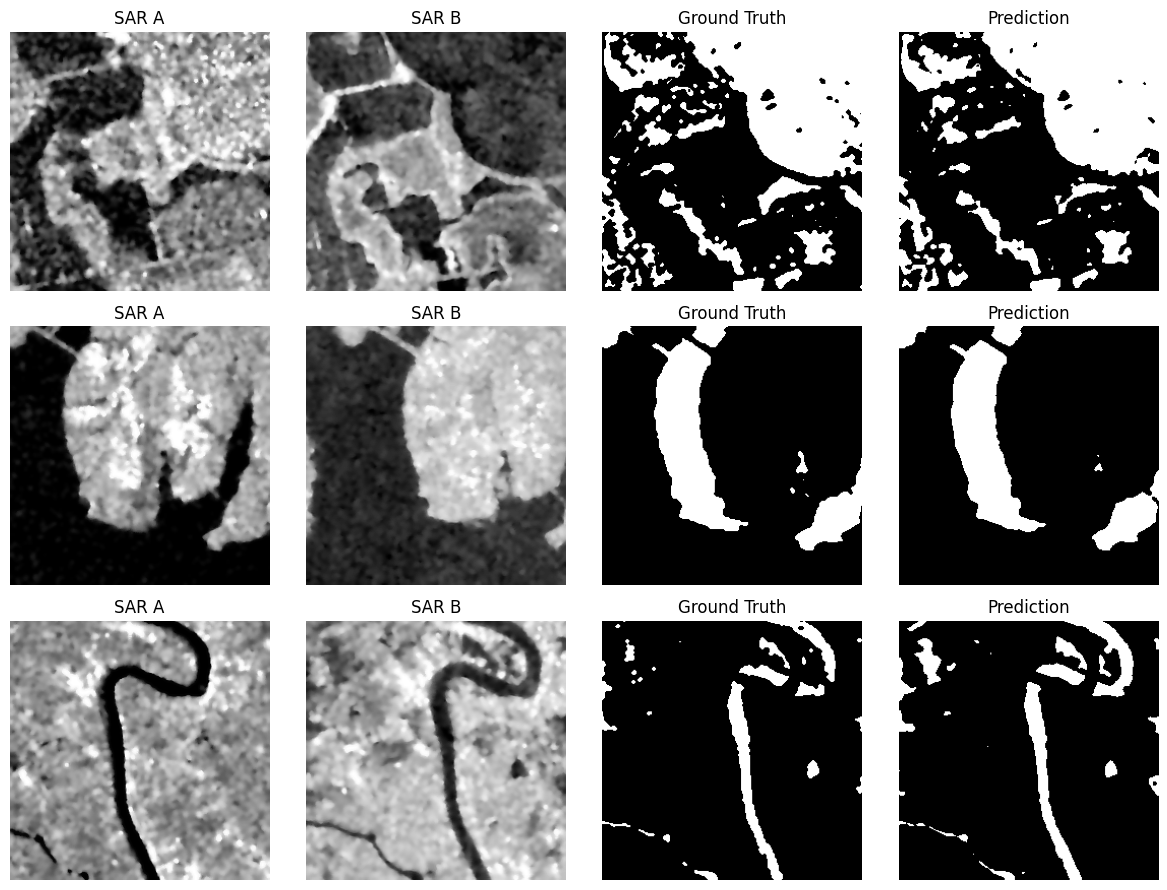

In [ ]:
def visualize_predictions(model, dataset, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3*num_samples))

    for i in range(num_samples):
        img, mask = dataset[i]
        img_in = img.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(img_in)

        pred = pred.squeeze().cpu().numpy()
        mask = mask.squeeze().cpu().numpy()
        img_np = img.permute(1, 2, 0).cpu().numpy()

        axes[i, 0].imshow(img_np[:,:,0], cmap="gray"); axes[i, 0].set_title("SAR A"); axes[i, 0].axis("off")
        axes[i, 1].imshow(img_np[:,:,1], cmap="gray"); axes[i, 1].set_title("SAR B"); axes[i, 1].axis("off")
        axes[i, 2].imshow(mask, cmap="gray"); axes[i, 2].set_title("Ground Truth"); axes[i, 2].axis("off")
        axes[i, 3].imshow(pred > 0.5, cmap="gray"); axes[i, 3].set_title("Prediction"); axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

# Example visualization
visualize_predictions(model, val_dataset, num_samples=3)


In [ ]:
val_loss, val_acc = evaluate(model, val_loader)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
print("Accuracy: ", val_acc:.4f * 100 )


Validation Loss: 0.1212, Validation Accuracy: 0.9551


In [ ]:
print("Accuracy: {:.2f}%".format(val_acc * 100))

Accuracy: 95.51%


In [ ]:
def dice_score(preds, masks, threshold=0.5):
    preds_bin = (preds > threshold).float()
    intersection = (preds_bin * masks).sum()
    union = preds_bin.sum() + masks.sum()
    dice = (2. * intersection) / (union + 1e-8)
    return dice.item()

# Evaluate Dice on validation set
dice_scores = []
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        dice_scores.append(dice_score(preds, masks))

print("Mean Dice Score on Validation:", np.mean(dice_scores))


Mean Dice Score on Validation: 0.9201399067889399


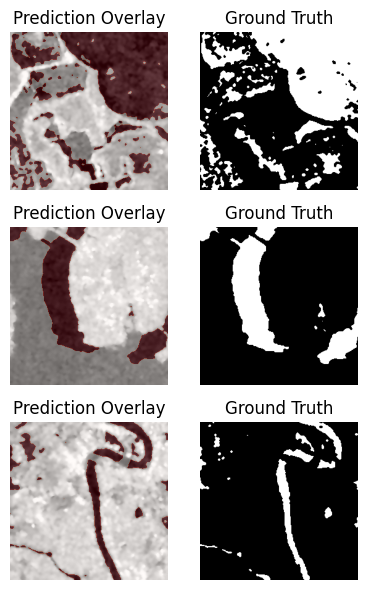

In [ ]:
def visualize_overlay(model, dataset, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 2, figsize=(4, 2*num_samples))

    for i in range(num_samples):
        img, mask = dataset[i]
        img_in = img.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(img_in)
        pred = pred.squeeze().cpu().numpy()
        img_np = img.permute(1,2,0).cpu().numpy()

        axes[i,0].imshow(img_np[:,:,1], cmap='gray')  # Post-flood image
        axes[i,0].imshow(pred>0.5, cmap='Reds', alpha=0.4)  # Overlay prediction
        axes[i,0].set_title("Prediction Overlay"); axes[i,0].axis("off")

        axes[i,1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
        axes[i,1].set_title("Ground Truth"); axes[i,1].axis("off")

    plt.tight_layout()
    plt.show()

# Example
visualize_overlay(model, val_dataset, num_samples=3)
